# **SDSE Final Project: Predicting Car Fuel Efficiency with Machine Learning**

Our notebook attempts to predict a given car's **combined fuel efficiency (MPG)** based on information that is available **before** buying the car:

- Make and type                 (SUV, sedan, etc.)
- Drivetrain                    (FWD, AWD, etc.)
- Engine displacement           (L)
- Number of cylinders           (dimensinoless)
- Transmission type             (automatic, manual, etc.)

Why this matters:

- Consumers can estimate real-world fuel costs for a car model even when independent test results are not widely available yet, such with new vehicle models and trims.
- Dealerships and fleet managers can compare many options quickly based on expected efficiency.
- Policy or sustainability teams can more immediately simulate how changing the mix of vehicles (more small engines, more hybrids, etc.) might affect fuel consumption and greenhouse/noise emissions.

The goal of this notebook is to explain how our code works:

1. Load and clean the dataset  
2. Encode categorical features and inputs/outputs of interest  
3. Train and evaluate a linear regression model  
4. Visualize one of the learned relationships  
5. Explore the categorical variables  
6. Prepare data for and train several neural network architectures

Each section has code and an explanation of why it is written this way.

## 1. Imports and Setup

Our code starts by importing:

- **pandas / numpy** for data manipulation  
- **matplotlib** for plotting  
- **scikit‑learn** tools for preprocessing and linear regression  
- **TensorFlow / Keras** for building neural networks

These libraries cover the whole workflow from raw CSV → features → models → evaluation → plots.

In [10]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

## 2. Loading the Dataset

Next, we read `car_data.csv` into a pandas DataFrame.  
Printing the first 5 rows helps verify that:

- The file path is correct  
- Columns have the expected names
- There are no obvious parsing issues

In [11]:
# Reading in the data
data = pd.read_csv("car_data.csv")
print("First 5 rows of data:")
print(data.head(5))

First 5 rows of data:
   city_mpg                         type  combination_mpg  cylinders  \
0        25                  midsize car               29        4.0   
1        26                  midsize car               30        4.0   
2        25  small sport utility vehicle               27        4.0   
3        26  small sport utility vehicle               29        4.0   
4        26  small sport utility vehicle               28        4.0   

   displacement drive fuel_type  highway_mpg   make     model transmission  \
0           2.5   fwd       gas           36  mazda         6            m   
1           2.5   fwd       gas           37  mazda         6            a   
2           2.5   fwd       gas           31  mazda  cx-5 2wd            a   
3           2.0   fwd       gas           34  mazda  cx-5 2wd            m   
4           2.0   fwd       gas           32  mazda  cx-5 2wd            a   

   year  
0  2014  
1  2014  
2  2014  
3  2014  
4  2014  


## 3. Defining Feature Columns and Target

Next, we decide which columns will be used as inputs (features) and which column is the output (target).

- `categorical` lists all string‑based variables we might want to explore.
- `numerical` contains the numeric engine characteristics that are important for fuel use.
- `output` is the target: combined MPG.
- `categorical_for_model` is a refined list of categorical columns used in the actual model.  
  We keep a fixed set of five categorical variables as required by the project guidelines, and avoid overly specific identifiers which would be difficult to generalize well, such as the model name.

In [33]:
# Feature lists
categorical = ['type', 'drive', 'make', 'model', 'transmission']
numerical = ['cylinders', 'displacement']
output = 'combination_mpg'
categorical_for_model = ['type', 'drive', 'fuel_type', 'make', 'transmission']

## 4. Data Cleaning and Preparation

Before training any model, our code handles missing values:

1. **Drop rows with missing target**:  
   If `combination_mpg` is missing, the data is unusable for supervised learning.

2. **Impute numerical features with the mean**:  
   This maintains a baseline that keeps all existing data while avoiding bias towards any existing value.

3. **Impute categorical features with the mode** (most frequent category):  
   This preserves the most likely class and keeps categories consistent.

After cleaning, our code builds:

- `feature_cols`: all columns that will be used as inputs
- `X`: the feature matrix  
- `y`: the target vector

In [ ]:
# Data preparation
data = data.dropna(subset=[output])

for col in numerical:
    if col in data.columns:
        data[col] = data[col].fillna(data[col].mean())

for col in categorical_for_model:
    if col in data.columns:
        data[col] = data[col].fillna(data[col].mode()[0])

# Defining feature matrix X and target y
feature_cols = categorical_for_model + numerical
X = data[feature_cols]
y = data[output]

print("\nFeature columns used for the model:")
print(feature_cols)
print(f"\nNumber of samples after cleaning: {len(X)}")


Feature columns used for the model:
['type', 'drive', 'fuel_type', 'make', 'transmission', 'cylinders', 'displacement']

Number of samples after cleaning: 550


## 5. One‑Hot Encoding and Linear Regression

Machine learning models like linear regression work with numbers, not strings.  
We therefore need to convert categorical features into a numeric format.

We use:

- **`ColumnTransformer` with `OneHotEncoder`**  
  - Each categorical column is expanded into one binary column per category.
  - `handle_unknown='ignore'` ensures the model can handle categories that only appear in the test set.

- **`Pipeline`** combining preprocessing and the `LinearRegression` estimator:  
  - Keeps the workflow "clean"  
  - Ensures that the same transformations are applied to training and test data in the correct order

We then perform a standard train/test split to estimate generalization performance and compute the R² score as our main metric.

In [35]:
# One-hot encoding and linear regression
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_for_model)
    ],
    remainder='passthrough'  # keep numerical columns as-is
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print(f"\nTrain size: {X_train.shape[0]} samples")
print(f"Test size: {X_test.shape[0]} samples")

# Fit the linear regression model
model.fit(X_train, y_train)

# Predict and evaluate with R^2
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"\nLinear Regression R² Score on test set: {r2:.3f}")


Train size: 440 samples
Test size: 110 samples

Linear Regression R² Score on test set: 0.800


In [30]:
# Feature Selection on LR
from sklearn.feature_selection import SequentialFeatureSelector


preprocessor.fit(X_train)
# Transform train and test sets
X_train_enc = preprocessor.transform(X_train)
X_test_enc  = preprocessor.transform(X_test)

n_select = X_train_enc.shape[1] - 20 # number of features to keep

estimator = LinearRegression()
#forward selection
# we could use the cv cross validation parameter as a hyperparameter to optimize/play with
sfs_forward = SequentialFeatureSelector(estimator, n_features_to_select=n_select, direction='forward',cv=5)

sfs_forward.fit(X_train_enc,y_train)
# Extract mask of selected features
selected_mask = sfs_forward.get_support()
print(selected_mask)

# Reduce train/test matrices
X_train_fs = X_train_enc[:, selected_mask]
X_test_fs  = X_test_enc[:, selected_mask]

# Fit a new model on selected features
lr_fs = LinearRegression()
lr_fs.fit(X_train_fs, y_train)

# Predict + evaluate
y_pred_forward = lr_fs.predict(X_test_fs)
r2_forward = r2_score(y_test, y_pred_forward)
print(f"\nForward Feature Selection Linear Regression R² Score on test set: {r2_forward:.3f}")


[ True  True False  True  True  True False  True  True  True False False
 False False False  True False  True  True  True False  True  True  True
 False  True  True False False  True  True  True  True  True False  True
 False False  True  True  True False False  True  True  True False  True
  True False False  True  True  True  True]

Forward Feature Selection Linear Regression R² Score on test set: 0.787


In [42]:
print(X_train_enc.shape[1])
# Categorical feature exploration
# for col in categorical:
    # print(f"\n{col}: {data[col].nunique()} unique classes")
    # print(data[col].value_counts().head(10))
    # print(col)
# print(data['make'].value_counts())
print(data['type'].value_counts())

55
type
small sport utility vehicle       157
subcompact car                     85
compact car                        83
two seater                         69
midsize car                        53
standard sport utility vehicle     34
minicompact car                    21
large car                          13
small station wagon                11
minivan                             8
standard pickup truck               7
small pickup truck                  7
midsize station wagon               2
Name: count, dtype: int64


## 6. Visualizing the Relationship with Engine Displacement

The full linear regression model uses many features, so it is hard to visualize directly.  
To build intuition, we look at a single numeric feature, engine `displacement`, and fit a simple one‑feature linear regression:

- Scatter plot: actual `displacement` vs. `combination_mpg`
- Trend line: best‑fit straight line using simple linear regression
- Equation printed on the plot: helps interpret how MPG changes with displacement

This **does not** show the full multivariate model but gives a view of one key relationship in the data that is maximimally understandable to our fleshy human eyes.

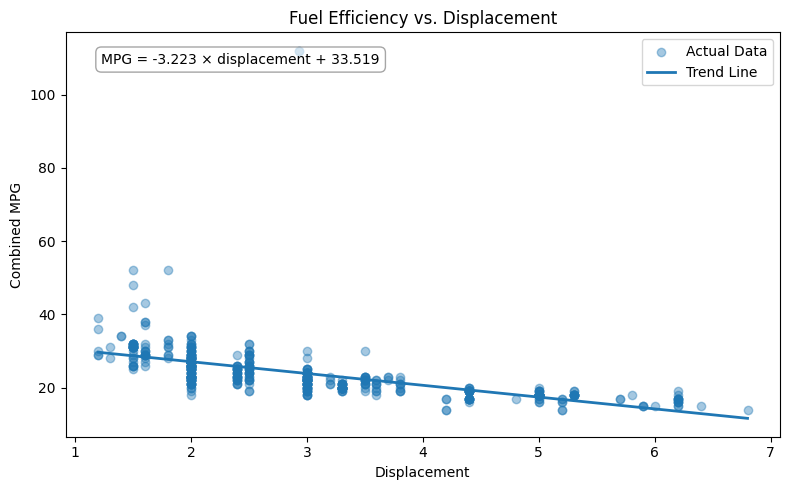

In [15]:
# Graphing a simple linear relationship with displacement
viz_feature = 'displacement'

# Extract single feature and target
X_viz = data[[viz_feature]].values
y_viz = data[output].values

# Fit a simple linear regression for visualization
simple_lr = LinearRegression()
simple_lr.fit(X_viz, y_viz)

# Line for plotting
x_line = np.linspace(X_viz.min(), X_viz.max(), 200).reshape(-1, 1)
y_line = simple_lr.predict(x_line)

# Equation components
slope = simple_lr.coef_[0]
intercept = simple_lr.intercept_
eq_text = f"MPG = {slope:.3f} × {viz_feature} + {intercept:.3f}"

# Plot
plt.figure(figsize=(8, 5))
plt.scatter(X_viz, y_viz, alpha=0.4, label='Actual Data')
plt.plot(x_line, y_line, linewidth=2, label='Trend Line')
plt.title(f"Fuel Efficiency vs. {viz_feature.capitalize()}")
plt.xlabel(viz_feature.capitalize())
plt.ylabel("Combined MPG")
plt.legend()

# Put the equation inside a nice box on the plot
plt.text(
    0.05, 0.95, eq_text,
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment='top',
    bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="gray", alpha=0.7)
)

plt.tight_layout()
plt.show()

## 7. Exploring Categorical Feature Distributions

Before or after modeling, it is useful to understand what the data looks like:

- How many unique values does each categorical column have?
- Which categories dominate the dataset? 

We print basic counts and then plot simple bar charts for each categorical variable.

This is important because:

- It visualizes highly imbalanced categories (if present), which may bias the model
- Some categories may have very few examples and might not be reliable for predictions


type: 13 unique classes
type
small sport utility vehicle       157
subcompact car                     85
compact car                        83
two seater                         69
midsize car                        53
standard sport utility vehicle     34
minicompact car                    21
large car                          13
small station wagon                11
minivan                             8
Name: count, dtype: int64

drive: 4 unique classes
drive
awd    215
fwd    178
rwd    115
4wd     42
Name: count, dtype: int64

make: 31 unique classes
make
bmw          72
jaguar       71
kia          69
mini         51
hyundai      38
audi         31
genesis      26
chevrolet    23
jeep         22
mazda        21
Name: count, dtype: int64

model: 276 unique classes
model
veloster              12
cooper convertible     9
g70 rwd                9
6                      8
cx-5 2wd               8
wrx                    7
sorento awd            7
sportage fwd           7
g70 awd       

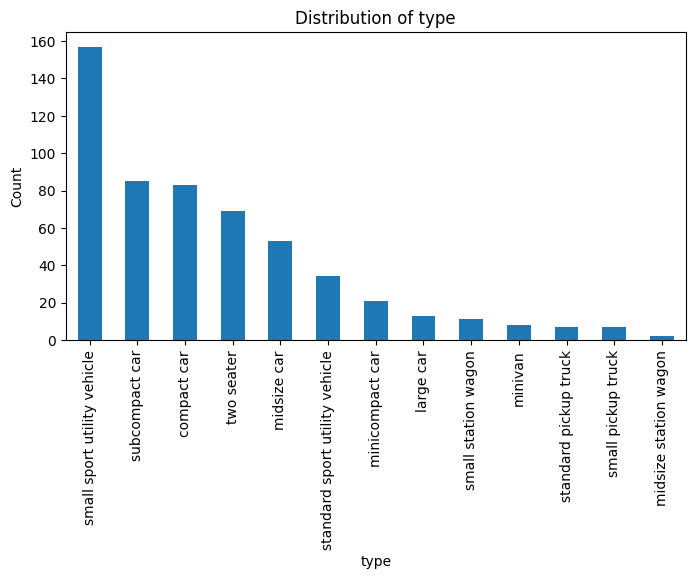

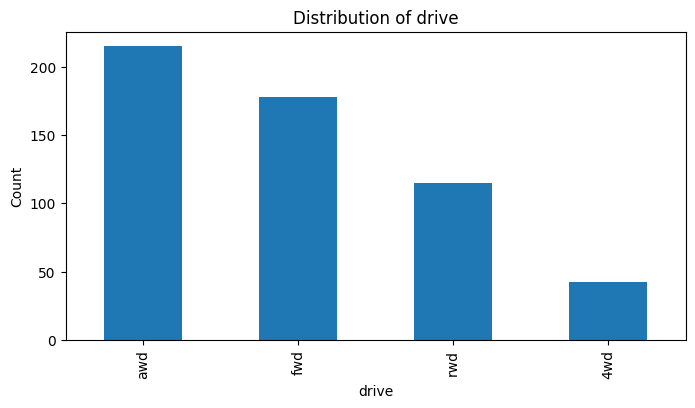

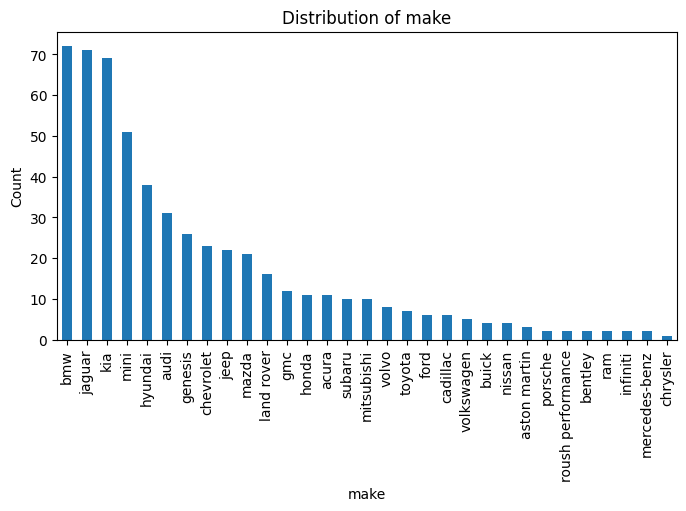

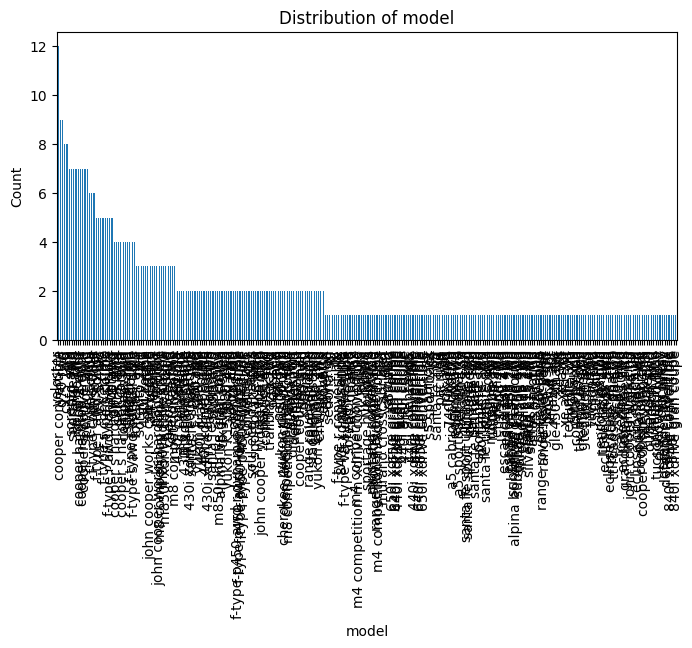

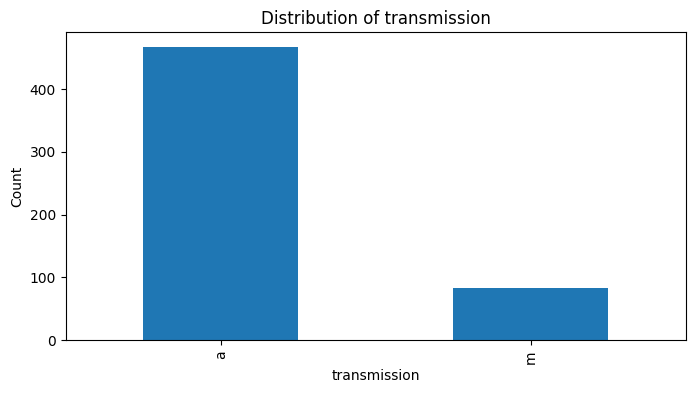

In [16]:
# Categorical feature exploration
for col in categorical:
    print(f"\n{col}: {data[col].nunique()} unique classes")
    print(data[col].value_counts().head(10))

for col in categorical:
    plt.figure(figsize=(8, 4))
    data[col].value_counts().plot(kind='bar')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")

plt.show()

## 8. Preparing Encoded Data for Neural Networks

Neural networks require purely numeric input and usually benefit from scaled features. We reuse the same preprocessing logic as for linear regression, but we explicitly:

1. Fit the `preprocessor` on the training data only to avoid data leakage.
2. Transform both train and test splits into encoded matrices.
3. Apply `StandardScaler` (without centering, `with_mean=False`) because the encoded data is sparse.  
   Scaling helps optimization algorithms like Adam converge faster, allowing our code to run more feasibly on less powerful computers.
4. Convert the resulting sparse matrices to dense arrays, which is what Keras expects by default

This ensures a fair comparison between the linear model and the neural networks that follow.

In [17]:
# ====== PREPARE NN DATA  ======

# 1. Fit preprocessor ONLY on training data
preprocessor.fit(X_train)

# 2. Transform train and test sets
X_train_enc = preprocessor.transform(X_train)
X_test_enc  = preprocessor.transform(X_test)

# 3. Scale features (works with sparse matrices)
scaler = StandardScaler(with_mean=False)
scaler.fit(X_train_enc)

X_train_enc = scaler.transform(X_train_enc)
X_test_enc  = scaler.transform(X_test_enc)

# 4. Convert to dense matrices for Keras
X_train_enc = X_train_enc.toarray()
X_test_enc  = X_test_enc.toarray()

print("Final input feature dimension:", X_train_enc.shape[1])

Final input feature dimension: 55


## 9. Neural Network Architectures

To explore non‑linear relationships, we implement four different neural network models:

- **Model A — Simple**:  
  - 1 hidden layer with 32 neurons (ReLU)  
  - Good baseline, fast to train

- **Model B — Deeper**:  
  - Two hidden layers (64 → 32 units)  
  - CAN model, more complex patterns

- **Model C — Regularized with Dropout**:  
  - Same idea as Model B but adds `Dropout(0.25)`  
  - Helps reduce overfitting by randomly dropping neurons during training

- **Model D — Wide with Batch Normalization**:  
  - Two wide layers (128 → 64 units)  
  - `BatchNormalization` after each hidd**en layer  
  - Makes training more stable and can speed up convergence

All models use:
- **Optimizer**: Adam
- **Loss**: Mean Squared Error (MSE)
- **Metric**: Mean Absolute Error (MAE), easier to interpret as “average error in MPG”

In [18]:
# ====== NN MODELS  ======

def build_model_A(input_dim):
    """Model A - Simple 1-hidden-layer network."""
    model = Sequential([
        Dense(32, activation='relu', input_dim=input_dim),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


def build_model_B(input_dim):
    """Model B - Deeper network with two hidden layers."""
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


def build_model_C(input_dim):
    """Model C - Adds dropout for regularization."""
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        Dropout(0.25),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


def build_model_D(input_dim):
    """Model D - Wide network using batch normalization."""
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        BatchNormalization(),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

## 10. Training, Early Stopping, and Evaluation

We train each neural network using:

- Early stopping (`EarlyStopping`) with:  
  - `patience=10`: if validation loss does not improve for 10 epochs, training stops  
  - `restore_best_weights=True`: we keep the model from the best epoch

For each model we:

1. Train on the encoded training data with a validation split.
2. Evaluate on the encoded test set to obtain MSE  and MAE.
3. Plot the training and validation loss curves to see whether the model is overfitting or underfitting.

This makes the comparison between different architectures transparent and well‑documented.

In [19]:
# Train and evaluate each model
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True)
]

models = {
    "Model A": build_model_A(X_train_enc.shape[1]),
    "Model B": build_model_B(X_train_enc.shape[1]),
    "Model C": build_model_C(X_train_enc.shape[1]),
    "Model D": build_model_D(X_train_enc.shape[1]),
}

history = {}
results = {}

for name, nn_model in models.items():
    print(f"Training {name}...")
    history[name] = nn_model.fit(
        X_train_enc, y_train,
        validation_split=0.2,
        epochs=100,
        batch_size=32,
        callbacks=callbacks,
        verbose=0
    )
    test_mse, test_mae = nn_model.evaluate(X_test_enc, y_test, verbose=0)
    results[name] = (test_mse, test_mae)
    print(f"{name} — Test MAE: {test_mae:.3f}")

c:\Users\laley\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Model A...
Model A — Test MAE: 2.016
Training Model B...
Model B — Test MAE: 21.370
Training Model C...
Model C — Test MAE: 19.263
Training Model D...
Model D — Test MAE: 23.762


## 11. Visualizing Training Curves

Finally, we plot the training loss and validation loss for each model across epochs.

Things to look for:

- If validation loss starts increasing while training loss keeps decreasing, then the model is overfitted.  
- If both losses are high and do not improve, then the model might be underpowered or features might not be informative enough

These plots help justify which neural network architectures are the most appropriate for this prediction task.

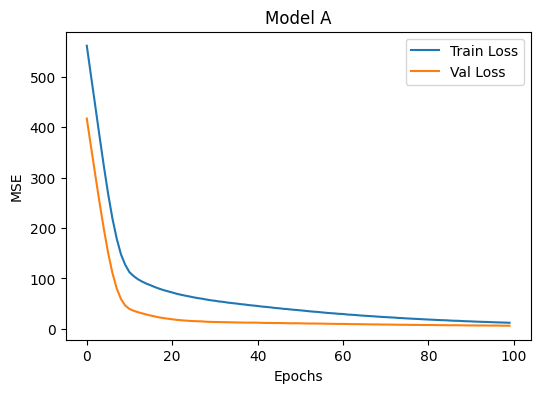

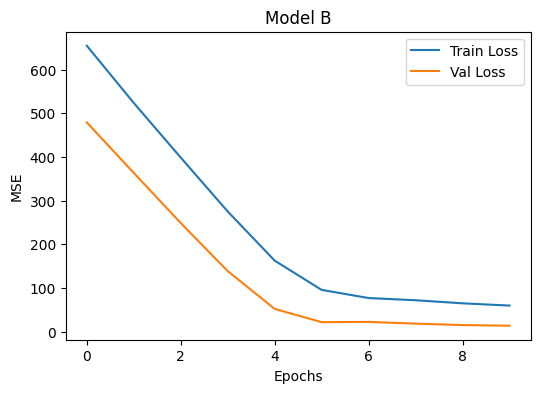

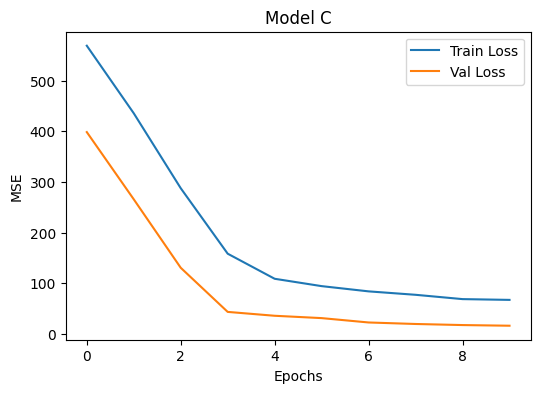

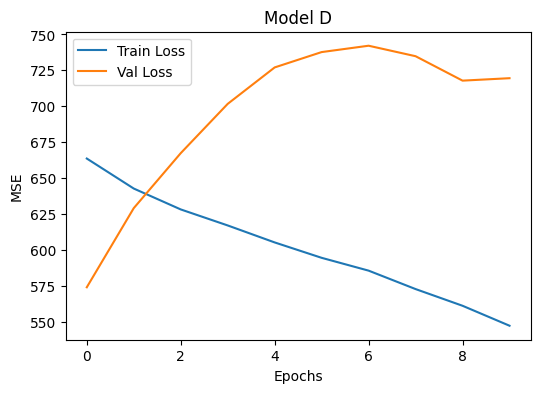

In [20]:
# Plot training curves for each model
for name in history:
    plt.figure(figsize=(6, 4))
    plt.plot(history[name].history['loss'], label='Train Loss')
    plt.plot(history[name].history['val_loss'], label='Val Loss')
    plt.title(name)
    plt.xlabel("Epochs")
    plt.ylabel("MSE")
    plt.legend()
    plt.show()